In [1]:
import pandas as pd
from vedo import Mesh, Plotter

In [2]:
df_features = pd.read_csv("mesh_features.csv")
X = df_features.drop(["mesh_name", "class"], axis=1)
X.head()

,area,volume,rectangularity,compactness,convexity,eccentricity,diameter,A3_bin_0,A3_bin_1,A3_bin_2,...,D4_bin_center_20,D4_bin_center_21,D4_bin_center_22,D4_bin_center_23,D4_bin_center_24,D4_bin_center_25,D4_bin_center_26,D4_bin_center_27,D4_bin_center_28,D4_bin_center_29
0,2.567595,0.338307,0.401367,1.307688,0.859908,1.143945,1.033568,0.000000,0.001750,0.006999,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
1,3.314142,0.359405,0.391703,2.491678,0.836037,1.798762,1.047357,0.002276,0.007587,0.008346,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
2,3.172938,0.263182,0.677445,4.077757,1.562505,4.874752,1.000015,0.009857,0.018817,0.020609,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
3,0.561321,0.027836,0.217335,2.018231,0.610430,12.169459,0.999651,0.017274,0.024952,0.044146,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667
4,0.671115,0.035075,0.251780,2.172427,0.686432,8.510702,0.998808,0.017117,0.028829,0.036036,...,0.666667,0.7,0.733333,0.766667,0.8,0.833333,0.866667,0.9,0.933333,0.966667


In [3]:
non_hist_features = ['area', 'volume', 'rectangularity', 'compactness', 'convexity', 'eccentricity', 'diameter']
hist_features = X.columns.difference(non_hist_features)
hist_features = hist_features[~(hist_features.str.contains('center'))]
grouped_columns = hist_features.groupby(hist_features.str[:2])
grouped_index_cols = {k: sorted([X.columns.get_loc(c) for c in v]) for k,v in grouped_columns.items()}
X[non_hist_features] = (X[non_hist_features] - X[non_hist_features].mean()) / X[non_hist_features].std()


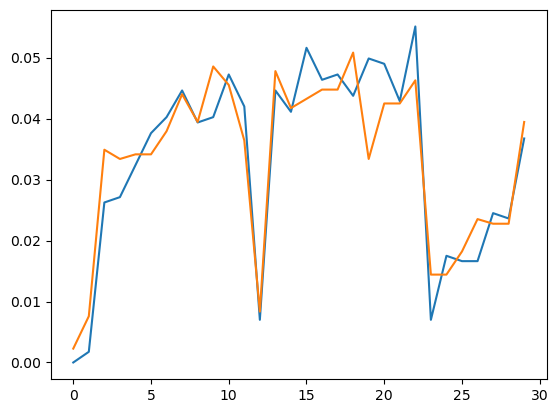

(np.float64(0.0025932519689464573), np.float64(0.0025932519689464573))

In [4]:
from scipy.stats import wasserstein_distance as emd
from matplotlib import pyplot as plt
import numpy as np

a3 = grouped_columns['A3']

u, v = X[a3].iloc[:2].to_numpy()
u.shape
# u, v
plt.plot(u)
plt.plot(v)
plt.show()
emd(u, v), emd(v, u) # def combined_dist(x, v):



In [5]:
def hist_distances(u, v, plot=False):
    dist = np.zeros(len(grouped_columns))
    for i, cols in enumerate(grouped_index_cols.values()):
        dist[i] = emd(u[cols], v[cols])
        if plot: 
            plt.plot(u[cols])
            plt.plot(v[cols])
            plt.show()
            print(i, dist[i])
    return dist

hist_distances(X.iloc[364].to_numpy(), X.iloc[147].to_numpy())


array([0.00262545, 0.00717358, 0.00469944, 0.00460239, 0.00683589])

In [6]:
def dist_func(u, v, weights = 1.):
    dist = np.zeros(len(non_hist_features) + len(grouped_columns))
    dist[:len(non_hist_features)] = np.abs(u[:len(non_hist_features)] - v[:len(non_hist_features)])
    dist[len(non_hist_features):] = hist_distances(u, v)

    return (weights * dist)

dist_func(X.iloc[364].to_numpy(), X.iloc[147].to_numpy()).sum()  # Car vs Biplane

np.float64(3.6857771361515743)

In [7]:
dist_func(X.iloc[0].to_numpy(), X.iloc[1].to_numpy()).sum()  # Two objects of the same class


np.float64(0.8669646773294263)

In [8]:
grouped_columns.keys()

dict_keys(['A3', 'D1', 'D2', 'D3', 'D4'])

In [9]:
def retrieve_topk(x, others, k=4, weights=1.):
    dist = np.fromiter((dist_func(x, o, weights).sum() for o in others), dtype=x.dtype)
    return dist.argsort()[:k]

X_np = X.to_numpy()
t = 364
best = retrieve_topk(X_np[t], X_np)
df_features[["mesh_name", "class"]].iloc[best]

,mesh_name,class
364,m1519.obj,Car
380,m1538.obj,Car
367,m1523.obj,Car
317,D00265.obj,Car


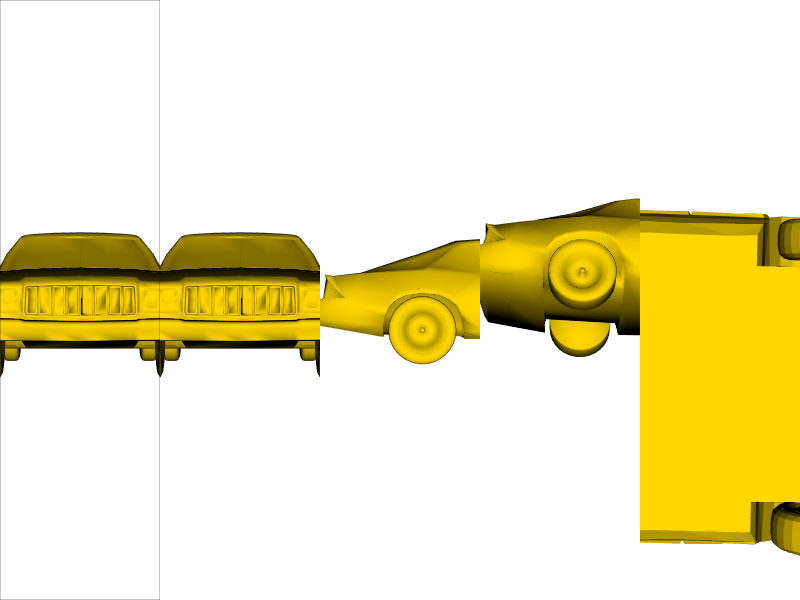

In [10]:
pltr = Plotter((1, 5))
pltr.add(Mesh(f"../shapes/{df_features.loc[t, "class"]}/{df_features.loc[t, "mesh_name"]}"), at=0)

for j, i in enumerate(best, start=1):
    pltr.add(Mesh(f"../shapes/{df_features.loc[i, "class"]}/{df_features.loc[i, "mesh_name"]}"), at=j)
pltr.show()

In [11]:
from pynndescent import NNDescent
index = NNDescent(X_np)

In [25]:
idx, dist = index.query(X_np[[851]], k=4)
idx.shape, idx.flatten().shape
dist.shape

(1, 4)

In [23]:
X_np[851].reshape(1, -1).shape, X_np[851] 

(1, 307)